## Загрузка данных

In [188]:
#pip install -U skorch

In [189]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import random
import torch
import torch.nn as nn
from torch import tensor
from torch.optim import Adam

from math import ceil
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from skorch import NeuralNetRegressor
from skorch.callbacks import EpochScoring, EarlyStopping

%matplotlib inline

In [190]:
# Чтение файла и получение информации о нем
df = pd.read_csv('/Users/user/Downloads/Star.csv')
display(df.head(3))
display(df.info())

,Unnamed: 0,Unnamed: 0.1,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,0,3068,0.0024,0.1700,16.12,0,Red
1,1,1,3042,0.0005,0.1542,16.60,0,Red
2,2,2,2600,0.0003,0.1020,18.70,0,Red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Unnamed: 0.1            240 non-null    int64  
 2   Temperature (K)         240 non-null    int64  
 3   Luminosity(L/Lo)        240 non-null    float64
 4   Radius(R/Ro)            240 non-null    float64
 5   Absolute magnitude(Mv)  240 non-null    float64
 6   Star type               240 non-null    int64  
 7   Star color              240 non-null    object 
dtypes: float64(3), int64(4), object(1)
memory usage: 15.1+ KB


None

Датафрейм содержит следующие признаки:

- Luminosity(L/Lo) - Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Radius(R/Ro) - Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Absolute magnitude(Mv) - Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Star color - Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды;
- Temperature (K) - Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

Столбец 'Unnamed: 0', 'Unnamed: 0.1' нам не нужны, удалим их.

In [191]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [192]:
# Проверим на наличие пропусков
df.isna().sum()

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [193]:
# Проверим на наличие дубликатов
df.duplicated().sum()

0

In [194]:
# Проверим уникальные значения признака Star type
df['Star color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
white                   3
Blue white              3
Yellowish White         3
Whitish                 2
Orange                  2
yellowish               2
Yellowish               1
Blue white              1
Pale yellow orange      1
Blue-White              1
Blue                    1
Orange-Red              1
White-Yellow            1
Name: Star color, dtype: int64

В столбце Star color имеются неявные дубликаты, переименуем их.

In [195]:
df['Star color'] = df['Star color'].replace({'Blue White': 'Blue-white', 'Blue white':'Blue-white',
                                             'Blue white ':'Blue-white','Blue-White':'Blue-white',
                                             'Blue ':'Blue', 'white':'White', 'yellowish':'Yellowish',
                                             'yellow-white':'Yellow-white','White-Yellow':'Yellow-white',
                                             'Yellowish White':'Yellow-white','Pale yellow orange':'Pale-yellow-orange',
                                             'Whitish':'White'})

In [196]:
# Проверим изменения
df['Star color'].value_counts()

Red                   112
Blue                   56
Blue-white             41
Yellow-white           12
White                  12
Yellowish               3
Orange                  2
Pale-yellow-orange      1
Orange-Red              1
Name: Star color, dtype: int64

In [197]:
# Создадим список для удаления строк
list_drop = ['Pale-yellow-orange', 'Orange-Red', 'Orange', 'Yellowish']
df = df.drop(df[df['Star color'].isin(list_drop)].index)

In [198]:
# Проверим изменения
df['Star color'].value_counts()

Red             112
Blue             56
Blue-white       41
Yellow-white     12
White            12
Name: Star color, dtype: int64

In [199]:
# Посмотрим на числовые характеристики датафрейма
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,233.000000,233.000000,233.000000,233.000000,233.000000
mean,10667.081545,105344.229902,231.550165,4.432408,2.472103
std,9642.455332,175764.026588,510.584292,10.600778,1.719649
min,1939.000000,0.000085,0.008400,-11.920000,0.000000
25%,3341.000000,0.000849,0.102000,-6.230000,1.000000
50%,6380.000000,0.022000,0.670000,10.340000,2.000000
75%,15680.000000,198000.000000,42.000000,13.780000,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Посмотрим на распределение значений признаков.

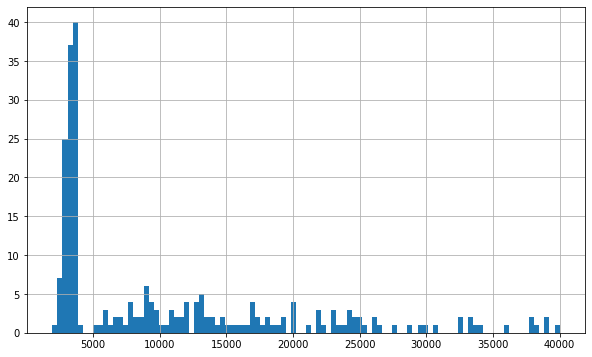

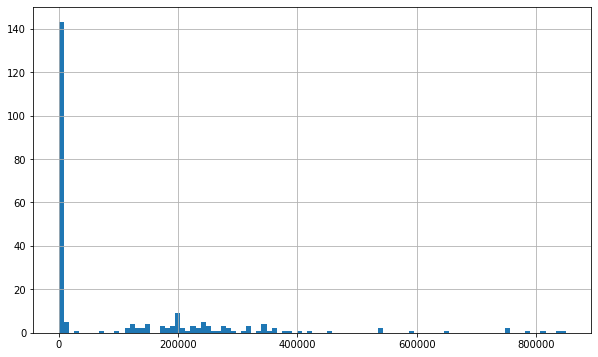

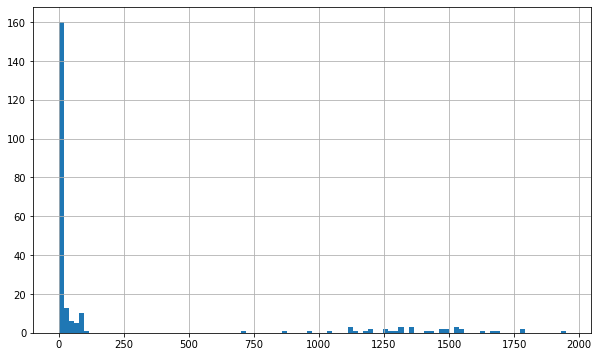

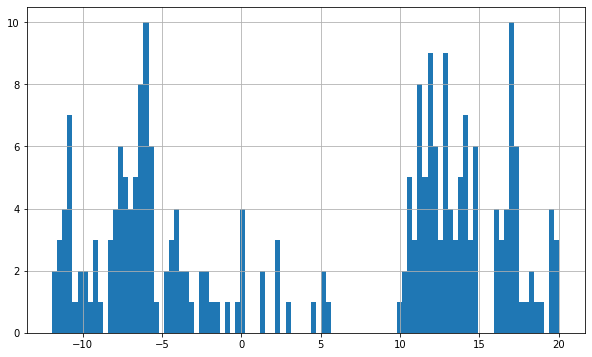

In [200]:
for i in df[['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']]:
    df[i].hist(bins=100, figsize=(10, 6))
    plt.show()

In [201]:
# Посмотрим на корреляцию признаков
df.corr()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
Temperature (K),1.000000,0.418671,0.075273,-0.430784,0.428876
Luminosity(L/Lo),0.418671,1.000000,0.497575,-0.690944,0.676098
Radius(R/Ro),0.075273,0.497575,1.000000,-0.602688,0.657387
Absolute magnitude(Mv),-0.430784,-0.690944,-0.602688,1.000000,-0.957018
Star type,0.428876,0.676098,0.657387,-0.957018,1.000000


В датафрейме был выявлен лишний столбец, который мы удалили, а также дубликаты в столбце Star color, которые мы заменили. Выбросов и аномальныз начений в данных нет, при этом имется большая корриляция между признаками радиус-светимость, радиус-звездная величина, радиус-тип звезды.

## Предобработка и анализ данных

In [202]:
# Создадим признаки и целевой признак
features = df.drop('Temperature (K)', axis=1)
target = df['Temperature (K)']

In [203]:
# Разделим на обучающую и валидационную выборки
features_train, features_test, target_train, target_test = train_test_split(features.copy(), target.copy(), test_size=.25, shuffle=True, 
                                                                            random_state=12345)

# Проверим соотношение выборок
display(features_train.shape, features_test.shape)
display(target_train.shape, target_test.shape)


(174, 5)

(59, 5)

(174,)

(59,)

In [204]:
# Масштабируем численные признаки
numeric = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [205]:
# Закодируем категориальные признаки
cat = ['Star color', 'Star type']

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe.fit(features_train[cat])

features_train_ohe = pd.DataFrame(ohe.transform(features_train[cat]), columns = ohe.get_feature_names(cat))
features_test_ohe = pd.DataFrame(ohe.transform(features_test[cat]), columns = ohe.get_feature_names(cat))

In [206]:
# Удаляем столбцы с категориальными признаками
features_train = features_train.drop(['Star color', 'Star type'], axis=1)
features_test = features_test.drop(['Star color', 'Star type'], axis=1)

In [207]:
# объединяем таблицы
features_train = pd.concat([features_train.reset_index(drop=True), features_train_ohe.reset_index(drop=True)], axis=1, ignore_index=False)
features_test = pd.concat([features_test.reset_index(drop=True), features_test_ohe.reset_index(drop=True)], axis=1, ignore_index=False)

In [208]:
# Проверим масштабирование и кодирование
display(features_train.head(3))
display(features_test.head(3))

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color_Blue,Star color_Blue-white,Star color_Red,Star color_White,Star color_Yellow-white,Star type_0,Star type_1,Star type_2,Star type_3,Star type_4,Star type_5
0,-0.588493,-0.434936,0.663949,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.588494,-0.435414,1.177476,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.521597,-0.422470,-0.891709,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color_Blue,Star color_Blue-white,Star color_Red,Star color_White,Star color_Yellow-white,Star type_0,Star type_1,Star type_2,Star type_3,Star type_4,Star type_5
0,0.996550,2.164792,-1.180039,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.588493,-0.435635,0.691274,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.603695,1.896492,-1.183808,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Подготовили датафрейм для построения модели, обработали категориальные и количественные данные.

## Построение базовой нейронной сети

Построим базовую нейронную сеть без оптимизации параметров с двумя скрытыми слоями, будем использовать функцию активации ReLU, количество эпох 1000, размер батча 20.

In [209]:
# Создадим тензоры
X_train = torch.FloatTensor(features_train.values)
X_test = torch.FloatTensor(features_test.values)

y_train = torch.FloatTensor(target_train.values)
y_test = torch.FloatTensor(target_test.values)

In [210]:
print('Кол-во строк и столбцов в X_train выборке:', X_train.shape)
print('Кол-во строк и столбцов в X_test выборке:', X_test.shape)

print('Кол-во строк и столбцов в y_train выборке:', y_train.shape)
print('Кол-во строк и столбцов в y_test выборке:', y_test.shape)

Кол-во строк и столбцов в X_train выборке: torch.Size([174, 14])
Кол-во строк и столбцов в X_test выборке: torch.Size([59, 14])
Кол-во строк и столбцов в y_train выборке: torch.Size([174])
Кол-во строк и столбцов в y_test выборке: torch.Size([59])


In [211]:
random_seed = 123
torch.manual_seed(random_seed)

In [212]:
# Зададим параметры слоев сети
n_in_neurons = 14
n_hidden_neurons_1 = 7
n_hidden_neurons_2 = 12
n_out_neurons = 1

In [213]:
# Объявим архитектуру сети
class Model(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Model, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()
        
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, mean=0, std=sqrt(2/n_hidden_neurons_1))
        nn.init.kaiming_uniform_(self.fc3.weight)
        nn.init.normal_(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act1(x)
        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [214]:
# Укажем параметры сети
net = Model(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
num_epochs = 1000
batch_size = 20
num_batches = ceil(len(X_train)/batch_size)

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/3286891750.py:14: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))


In [215]:
# Найдем значение RMSE
for epoch in range(num_epochs):
    net.train()
    order = np.random.permutation(len(X_train))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds_train = net.forward(X_batch).flatten()
       
        loss_value_train = torch.sqrt(loss(preds_train, y_batch))
        loss_value_train.backward()
                
        optimizer.step()

    if epoch % 10 == 0 or epoch == num_epochs:
        net.eval()
        with torch.no_grad():
            preds_test = net.forward(X_test).flatten()
            RMSE_loss = torch.sqrt(loss(preds_test, y_test))
            print(f'Эпоха: {epoch}, RMSE: {RMSE_loss}')

Эпоха: 0, RMSE: 15691.0087890625
Эпоха: 10, RMSE: 15474.330078125
Эпоха: 20, RMSE: 12732.3984375
Эпоха: 30, RMSE: 8307.8798828125
Эпоха: 40, RMSE: 6796.134765625
Эпоха: 50, RMSE: 6201.09619140625
Эпоха: 60, RMSE: 5858.17529296875
Эпоха: 70, RMSE: 5661.669921875
Эпоха: 80, RMSE: 5523.623046875
Эпоха: 90, RMSE: 5430.6748046875
Эпоха: 100, RMSE: 5326.97607421875
Эпоха: 110, RMSE: 5332.3076171875
Эпоха: 120, RMSE: 5265.5869140625
Эпоха: 130, RMSE: 5268.22509765625
Эпоха: 140, RMSE: 5264.7822265625
Эпоха: 150, RMSE: 5234.66064453125
Эпоха: 160, RMSE: 5199.04443359375
Эпоха: 170, RMSE: 5189.556640625
Эпоха: 180, RMSE: 5175.7490234375
Эпоха: 190, RMSE: 5157.88916015625
Эпоха: 200, RMSE: 5156.54443359375
Эпоха: 210, RMSE: 5120.287109375
Эпоха: 220, RMSE: 5142.29248046875
Эпоха: 230, RMSE: 5128.64990234375
Эпоха: 240, RMSE: 5105.11279296875
Эпоха: 250, RMSE: 5122.7919921875
Эпоха: 260, RMSE: 5112.70703125
Эпоха: 270, RMSE: 5129.45263671875
Эпоха: 280, RMSE: 5146.27001953125
Эпоха: 290, RMSE: 51

In [216]:
RMSE_loss

tensor(4743.5679)

In [217]:
# Создадим функцию для построения графика "Факт-Прогноз"
def graph_predict(x, y):
        
    barWidth1 = 1
    barWidth2 = 0.5
    x_range = np.arange(len(y))
    
    plt.bar(x_range, y.data.numpy(), color='#aae6f2', width=barWidth1/2, edgecolor='#c3d5e8', label='Факт')
    plt.bar(x_range, x.data.numpy(), color='#ffc001', width=barWidth2/2, edgecolor='#c3d5e8', label='Прогноз')
    
    plt.axhline(y=0, color='gray')
    plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0.25, -0.3, 0.5, 0.5), prop={'size':25}, ncol = 2)
    plt.ylabel("Температура звезды", fontsize=28, weight='bold')
    plt.xlabel("Номер звезды в таблице данных", fontsize=28, weight='bold')
    
    plt.rcParams['figure.figsize'] = [25, 7]
    
    plt.rcParams.update({'font.size': 28})    
    plt.box(False)
    plt.savefig('plt', bbox_inches = "tight")
    plt.show()

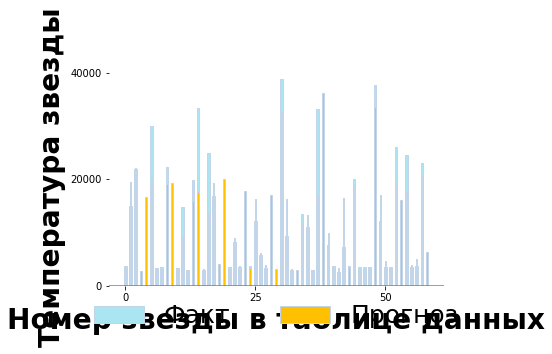

In [218]:
# Построим график
graph_predict(preds_test, y_test)

Базовая модель нейронной сети с параметрами n_hidden_neurons_1 = 7, n_hidden_neurons_2 = 12 показала значение RMSE 4877. Улучшим модель, используя перебор количества нейронов в скрытых слоях, а также используем BatchNorm и Dropout.

## Улучшение модели

In [219]:
# X_train = torch.FloatTensor(X_train) 
# X_test = torch.FloatTensor(X_test) 
# y_train = torch.FloatTensor(y_train) 
# y_test = torch.FloatTensor(y_test) 
X_train = tensor(X_train, dtype=torch.float32)
X_test = tensor(X_test, dtype=torch.float32)
y_train = tensor(y_train.reshape(-1,1), dtype=torch.float32)
y_test = tensor(y_test.reshape(-1,1), dtype=torch.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/3304705297.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = tensor(X_train, dtype=torch.float32)
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/3304705297.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = tensor(X_test, dtype=torch.float32)
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/3304705297.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = tensor(y_train.reshape(-1,1), dtype=torch.float32)
/var/fo

(torch.Size([174, 14]),
 torch.Size([59, 14]),
 torch.Size([174, 1]),
 torch.Size([59, 1]))

In [220]:
class Model_improve(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, 
                 dropout_1, dropout_2, activation_1, activation_2, activation_3):
        super(Model_improve, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = activation_1
        self.dp1 = nn.Dropout(dropout_1)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.act2 = activation_2
        self.dp2 = nn.Dropout(dropout_2)
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = activation_3
        
        nn.init.kaiming_uniform_(self.fc1.weight)
        nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
        
        nn.init.kaiming_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc2.bias, mean=0, std=sqrt(2/n_hidden_neurons_1))
       
        nn.init.kaiming_uniform_(self.fc3.weight)
        nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dp2(x)

        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [221]:
net = Model_improve(n_in_neurons, n_hidden_neurons_1, 36, n_out_neurons, 
                    0.8, 0.5, nn.ReLU(), nn.ReLU(), nn.ReLU())

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


In [333]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

skorch_regressor = NeuralNetRegressor(module=net, 
                                      device='cpu',  
                                      verbose=10,
                                      batch_size=40,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=1000, 
                                      lr=0.01,
                                      criterion=torch.nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping(lower_is_better=True, monitor='RMSE', patience=5))
            ], 
                                     )

In [334]:
skorch_regressor.fit(X_train, y_train)

  epoch        RMSE     train_loss      valid_loss     dur
-------  ----------  -------------  --------------  ------
      1  10589.5879  70105913.5540  112139384.0000  0.0178
      2  10539.7227  66049173.8705  111085752.0000  0.0137
      3  10459.3574  69887420.4892  109398152.0000  0.0101
      4  10425.4014  71414573.3525  108688992.0000  0.0098
      5  10417.3047  77876008.1151  108520232.0000  0.0240
      6  10204.7471  62955079.3669  104136856.0000  0.0152
      7  10165.4023  74664004.3741  103335400.0000  0.0129
      8  10125.2744  65471931.5108  102521184.0000  0.0143
      9  10068.5664  70571298.5324  101376024.0000  0.0190
     10  9718.4287  74547198.0432  94447848.0000  0.0098
     11  9862.2314  66506720.5755  97263600.0000  0.0267
     12  10005.7666  66708229.0647  100115352.0000  0.0131
     13  10047.8535  70673507.3957  100959360.0000  0.0152
     14  10015.9404  73653187.7986  100319064.0000  0.0130
Stopping since RMSE has not improved in the last 5 epochs.


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Model_improve(
    (fc1): Linear(in_features=14, out_features=7, bias=True)
    (bn1): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU()
    (dp1): Dropout(p=0.8, inplace=False)
    (fc2): Linear(in_features=7, out_features=36, bias=True)
    (bn2): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU()
    (dp2): Dropout(p=0.5, inplace=False)
    (fc3): Linear(in_features=36, out_features=1, bias=True)
    (act3): ReLU()
  ),
)

In [335]:
print("Train RMSE : {}".format(sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
print("Test  RMSE : {}".format(sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

Train RMSE : 8106.981682475914
Test  RMSE : 9518.713358432431


In [336]:
params = {
    'module__n_in_neurons':[14],
    'module__n_hidden_neurons_1': range(1, 150, 2),
    'module__n_hidden_neurons_2': range(1, 150, 2),
    'module__n_out_neurons':[1],
    'module__dropout_1': [0, 0.2, 0.4, 0.6, 0.8],
    'module__dropout_2': [0, 0.2, 0.4, 0.6, 0.8],
    'module__activation_1': [nn.LeakyReLU(), nn.ReLU(), nn.Tanh(), nn.ELU()],
    'module__activation_2': [nn.LeakyReLU(), nn.ReLU(), nn.Tanh(), nn.ELU()],
    'module__activation_3': [nn.LeakyReLU(), nn.ReLU(), nn.Tanh(), nn.ELU()],
    'lr': [0.01, 0.02]
}

In [337]:
%%time 
grid = RandomizedSearchCV(skorch_regressor, params, cv=3, scoring="neg_root_mean_squared_error", 
                          verbose=3, random_state=123) 
grid.fit(X_train, y_train.reshape(-1,1)) 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
  epoch        RMSE      train_loss      valid_loss     dur
-------  ----------  --------------  --------------  ------
      1  13036.4834  167484768.6957  169949904.0000  0.0069
      2  13036.2285  167472306.0870  169943280.0000  0.0076
      3  13035.9482  167466633.0435  169935920.0000  0.0082
      4  13035.6729  167454301.9130  169928768.0000  0.0075
      5  13035.3975  167450422.2609  169921584.0000  0.0095
      6  13035.0723  167448534.9565  169913136.0000  0.0123
      7  13034.7471  167412561.3913  169904624.0000  0.0092
      8  13034.4414  167408130.7826  169896656.0000  0.0234
      9  13034.0654  167396499.4783  169886864.0000  0.0125
     10  13033.6240  167394364.5217  169875344.0000  0.0087
     11  13033.1484  167367570.0870  169862960.0000  0.0171
     12  13032.6064  167346491.8261  169848832.0000  0.0132
     13  13031.9795  167329426.0870  169832496.0000  0.0123


/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     14  13031.1855  167350162.0870  169811792.0000  0.0222
     15  13030.3594  167320816.6957  169790256.0000  0.0226
     16  13029.4062  167255631.3043  169765440.0000  0.0086
     17  13028.4355  167258181.5652  169740144.0000  0.0170
     18  13027.5469  167217076.1739  169716960.0000  0.0161
     19  13026.5859  167234192.6957  169691952.0000  0.0137
     20  13025.6416  167188136.3478  169667344.0000  0.0078
     21  13024.7900  167151489.3913  169645152.0000  0.0144
     22  13023.7764  167157838.6087  169618768.0000  0.0112
     23  13022.8105  167116635.8261  169593584.0000  0.0100
     24  13021.4111  167145279.3043  169557152.0000  0.0140
     25  13020.3203  167048276.8696  169528752.0000  0.0137
     26  13019.0312  166963677.9130  169495184.0000  0.0132
     27  13017.5830  166980150.2609  169457456.0000  0.0135
     28  13016.7256  166973119.3043  169435136.0000  0.0088
     29  13015.5781  166965842.0870  169405280.0000  0.0112
     30  13014.5400  166920321.3913  169

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     21  14762.3223  223338413.9130  217926160.0000  0.0147
     22  14761.2793  223339657.7391  217895376.0000  0.0145
     23  14760.5195  223255680.0000  217872944.0000  0.0083
     24  14759.2627  223237307.8261  217835824.0000  0.0115
     25  14758.1006  223214206.6087  217801488.0000  0.0094
     26  14757.0508  223099735.6522  217770512.0000  0.0098
     27  14755.7676  223125455.3043  217732656.0000  0.0102
     28  14754.0107  223012993.3913  217680832.0000  0.0094
     29  14752.2930  223046235.8261  217630144.0000  0.0099
     30  14750.8398  223050603.1304  217587312.0000  0.0094
     31  14749.3574  222892428.5217  217543552.0000  0.0115
     32  14748.0703  222815627.1304  217505584.0000  0.0108
     33  14745.9219  222955792.6957  217442224.0000  0.0106
     34  14743.4531  222747629.9130  217369424.0000  0.0109
     35  14741.2559  222625889.3913  217304592.0000  0.0095
     36  14739.1357  222681469.2174  217242112.0000  0.0117
     37  14737.0312  222546699.1304  217

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     16  14764.2051  179666370.9565  217981744.0000  0.0098
     17  14762.9424  179656939.6522  217944464.0000  0.0082
     18  14761.5088  179580318.0870  217902128.0000  0.0086
     19  14760.1953  179569820.3478  217863344.0000  0.0104
     20  14758.7480  179563857.9130  217820656.0000  0.0099
     21  14757.2109  179492050.2609  217775248.0000  0.0129
     22  14755.7773  179464645.0435  217732992.0000  0.0100
     23  14754.2588  179449425.2174  217688144.0000  0.0076
     24  14752.5947  179341795.3043  217639056.0000  0.0082
     25  14751.0039  179323795.6522  217592128.0000  0.0078
     26  14749.4121  179255718.2609  217545152.0000  0.0113
     27  14747.6426  179245270.4348  217492944.0000  0.0117
     28  14745.5391  179185890.9565  217430896.0000  0.0102
     29  14743.5811  179179375.6522  217373200.0000  0.0114
     30  14742.1807  179163520.6957  217331904.0000  0.0134
     31  14739.7285  178984119.1304  217259584.0000  0.0091
     32  14736.8057  178870925.9130  217

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: n

      4  14776.4854  179905727.3043  218344528.0000  0.0092
      5  14775.5801  179893797.9130  218317760.0000  0.0076
      6  14774.8828  179885416.8696  218297152.0000  0.0083
      7  14774.3994  179878909.0435  218282896.0000  0.0071
      8  14774.1211  179870437.5652  218274640.0000  0.0086
      9  14773.7471  179861957.7391  218263616.0000  0.0077
     10  14773.5596  179855670.0870  218258064.0000  0.0104
     11  14773.2197  179844522.6087  218248016.0000  0.0109
     12  14773.0684  179833412.3478  218243536.0000  0.0112
     13  14772.8105  179819764.3478  218235920.0000  0.0130
Stopping since RMSE has not improved in the last 5 epochs.
[CV 3/3] END lr=0.01, module__activation_1=ELU(alpha=1.0), module__activation_2=ELU(alpha=1.0), module__activation_3=ReLU(), module__dropout_1=0.6, module__dropout_2=0, module__n_hidden_neurons_1=107, module__n_hidden_neurons_2=5, module__n_in_neurons=14, module__n_out_neurons=1; total time=   0.2s
  epoch        RMSE      train_loss      

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     17  13014.4678  166948470.2609  169376352.0000  0.0131
     18  13013.0029  166913792.0000  169338240.0000  0.0101
     19  13011.7148  166882817.3913  169304720.0000  0.0107
     20  13010.3125  166843507.4783  169268256.0000  0.0106
     21  13008.8760  166811658.4348  169230832.0000  0.0090
     22  13007.4980  166777597.2174  169195008.0000  0.0116
     23  13006.1719  166739212.5217  169160512.0000  0.0102
     24  13004.8525  166709385.7391  169126192.0000  0.0106
     25  13003.5391  166673707.8261  169092016.0000  0.0112
     26  13002.1738  166643090.7826  169056512.0000  0.0122
     27  13000.8242  166615219.4783  169021440.0000  0.0119
     28  12999.5596  166579116.5217  168988544.0000  0.0103
     29  12998.2920  166545702.2609  168955584.0000  0.0077
     30  12997.0361  166512498.7826  168922960.0000  0.0092
     31  12995.7529  166485207.6522  168889600.0000  0.0111
     32  12994.4697  166444234.4348  168856272.0000  0.0091
     33  12993.2227  166417096.3478  168

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     20  14751.1680  222954916.1739  217596944.0000  0.0087
     21  14749.5488  222912406.2609  217549200.0000  0.0103
     22  14747.9775  222868580.1739  217502864.0000  0.0072
     23  14746.4697  222821776.6957  217458368.0000  0.0094
     24  14745.0020  222776293.5652  217415088.0000  0.0076
     25  14743.5381  222728254.6087  217371920.0000  0.0097
     26  14742.1572  222678034.0870  217331216.0000  0.0113
     27  14740.7988  222639611.8261  217291136.0000  0.0095
     28  14739.4434  222595397.5652  217251184.0000  0.0077
     29  14738.0723  222548013.9130  217210768.0000  0.0103
     30  14736.6533  222503312.6957  217168960.0000  0.0110
     31  14735.2852  222469754.4348  217128624.0000  0.0074
     32  14733.8828  222423532.5217  217087296.0000  0.0130
     33  14732.5820  222382637.9130  217048976.0000  0.0098
     34  14731.2373  222331392.0000  217009344.0000  0.0097
     35  14729.8555  222295652.1739  216968624.0000  0.0074
     36  14728.4580  222258245.5652  216

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     20  14753.4736  179256761.5652  217664960.0000  0.0111
     21  14751.9785  179224769.2174  217620880.0000  0.0092
     22  14750.6855  179195961.9130  217582720.0000  0.0074
     23  14749.3398  179151912.1739  217543056.0000  0.0076
     24  14748.0352  179114278.9565  217504528.0000  0.0111
     25  14746.6475  179079156.3478  217463552.0000  0.0121
     26  14745.4688  179048469.2174  217428864.0000  0.0072
     27  14744.2275  179008735.3043  217392240.0000  0.0084
     28  14743.0322  178970460.6957  217356992.0000  0.0105
     29  14741.7119  178935484.6957  217318064.0000  0.0124
     30  14740.1328  178898419.4783  217271536.0000  0.0075
     31  14738.7637  178867991.6522  217231152.0000  0.0107
     32  14737.3350  178824958.4348  217189040.0000  0.0113
     33  14736.0459  178794914.2609  217151088.0000  0.0072
     34  14734.7998  178757043.1304  217114320.0000  0.0101
     35  14733.4414  178716338.9565  217074304.0000  0.0091
     36  14732.1016  178692546.2609  217

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     19  12879.5449  163060409.7391  165882672.0000  0.0092
     20  12864.4473  162641424.6957  165494032.0000  0.0108
     21  12844.6328  161781222.9565  164984592.0000  0.0093
     22  12826.4209  161436910.6087  164517072.0000  0.0079
     23  12805.0010  161057570.7826  163968048.0000  0.0083
     24  12783.7275  159849929.0435  163423696.0000  0.0074
     25  12764.6191  159535602.0870  162935504.0000  0.0114
     26  12742.6514  158572740.1739  162375152.0000  0.0105
     27  12719.4492  157595529.7391  161784400.0000  0.0079
     28  12694.9639  157447888.0000  161162096.0000  0.0109
     29  12667.5762  156467935.3043  160467488.0000  0.0118
     30  12643.8271  155407453.2174  159866368.0000  0.0077
     31  12615.6699  155203622.9565  159155152.0000  0.0107
     32  12580.0469  153884555.1304  158257568.0000  0.0111
     33  12534.6729  152168624.6957  157118048.0000  0.0081
     34  12498.6240  152065065.7391  156215600.0000  0.0106
     35  12471.4346  151125829.5652  155

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     19  14590.4258  218343088.6957  212880528.0000  0.0126
     20  14569.5986  218206757.5652  212273216.0000  0.0109
     21  14548.6270  217432162.7826  211662544.0000  0.0078
     22  14524.2188  216910868.8696  210952912.0000  0.0080
     23  14502.7812  216062633.7391  210330672.0000  0.0077
     24  14477.3535  215205257.7391  209593744.0000  0.0111
     25  14453.2900  214091084.5217  208897600.0000  0.0114
     26  14425.8262  212839048.3478  208104448.0000  0.0119
     27  14392.3926  212909765.5652  207140992.0000  0.0083
     28  14351.3906  212076307.4783  205962416.0000  0.0112
     29  14307.8584  210181419.1304  204714800.0000  0.0113
     30  14264.8662  209133414.9565  203486400.0000  0.0082
     31  14226.8779  207912292.1739  202404032.0000  0.0088
     32  14189.2598  207542750.6087  201335056.0000  0.0121
     33  14150.3711  205092683.1304  200233024.0000  0.0112
     34  14106.5508  205349522.0870  198994768.0000  0.0078
     35  14062.1279  202720250.4348  197

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     19  14554.4092  174938717.3913  211830832.0000  0.0090
     20  14525.2754  175131247.3043  210983616.0000  0.0079
     21  14498.6230  173837972.1739  210210064.0000  0.0079
     22  14469.6104  173158481.9130  209369616.0000  0.0095
     23  14431.0117  172865061.9130  208254128.0000  0.0081
     24  14394.0312  171598182.7826  207188144.0000  0.0082
     25  14355.0537  171197861.2174  206067568.0000  0.0090
     26  14318.9277  170697356.1739  205031696.0000  0.0088
     27  14277.5977  169320089.0435  203849808.0000  0.0111
     28  14234.8887  168565588.3478  202632048.0000  0.0076
     29  14195.8555  166557803.0435  201522304.0000  0.0110
     30  14155.0361  165771092.1739  200365008.0000  0.0121
     31  14107.8994  166327517.1304  199032848.0000  0.0074
     32  14063.5117  163922846.6087  197782352.0000  0.0118
     33  14020.6982  162522544.0870  196579984.0000  0.0119
     34  13974.3447  161727751.0435  195282288.0000  0.0080
     35  13927.9844  158988574.5217  193

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     22  13013.6426  166820695.6522  169354896.0000  0.0096
     23  13012.3389  166778134.9565  169320960.0000  0.0110
     24  13011.0039  166734494.6087  169286224.0000  0.0075
     25  13009.3203  166694620.5217  169242416.0000  0.0087
     26  13007.8926  166648620.5217  169205264.0000  0.0109
     27  13006.4883  166597883.1304  169168736.0000  0.0073
     28  13005.2900  166542864.0000  169137552.0000  0.0134
     29  13003.1133  166488356.8696  169080976.0000  0.0115
     30  13001.0166  166441657.7391  169026448.0000  0.0073
     31  12999.0371  166380264.3478  168974960.0000  0.0109
     32  12997.2783  166326407.6522  168929216.0000  0.0102
     33  12996.1934  166273579.8261  168901040.0000  0.0073
     34  12993.8369  166209177.0435  168839792.0000  0.0106
     35  12991.4219  166145236.8696  168777056.0000  0.0101
     36  12989.6719  166089628.5217  168731600.0000  0.0081
     37  12988.3809  166025711.3043  168698016.0000  0.0105
     38  12985.8086  165956232.3478  168

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     21  14754.6162  222976601.0435  217698704.0000  0.0117
     22  14753.4854  222919051.1304  217665296.0000  0.0076
     23  14752.3516  222852512.0000  217631888.0000  0.0108
     24  14750.8691  222784861.2174  217588112.0000  0.0074
     25  14748.7441  222719393.3913  217525456.0000  0.0089
     26  14746.8740  222648289.3913  217470272.0000  0.0077
     27  14744.7773  222581569.3913  217408464.0000  0.0071
     28  14742.6807  222507106.7826  217346608.0000  0.0134
     29  14740.9326  222430436.1739  217295104.0000  0.0079
     30  14739.2725  222356781.9130  217246160.0000  0.0108
     31  14737.2490  222270112.0000  217186496.0000  0.0115
     32  14735.6973  222188939.1304  217140752.0000  0.0073
     33  14733.2578  222103012.1739  217068880.0000  0.0115
     34  14730.5371  222015517.2174  216988736.0000  0.0113
     35  14727.8525  221929864.3478  216909648.0000  0.0078
     36  14724.3770  221849280.0000  216807296.0000  0.0104
     37  14721.6133  221742149.5652  216

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     21  14747.0107  179144734.0870  217474320.0000  0.0085
     22  14746.3291  179082663.4783  217454208.0000  0.0083
     23  14744.1133  179014326.7826  217388880.0000  0.0073
     24  14741.9619  178954693.7391  217325424.0000  0.0072
     25  14739.9141  178894056.8696  217265072.0000  0.0075
     26  14736.6475  178821291.6522  217168768.0000  0.0075
     27  14730.1650  178749622.9565  216977792.0000  0.0075
     28  14728.6807  178674711.4783  216934016.0000  0.0071
     29  14730.9873  178596192.8696  217001984.0000  0.0074
     30  14724.5908  178523250.6087  216813584.0000  0.0074
     31  14720.0000  178433103.4783  216678384.0000  0.0074
     32  14718.3262  178347966.6087  216629136.0000  0.0072
     33  14714.5361  178250867.8261  216517584.0000  0.0073
     34  14709.7754  178175126.0870  216377488.0000  0.0076
     35  14704.4287  178086105.0435  216220224.0000  0.0087
     36  14697.0977  177981956.6957  216004672.0000  0.0106
     37  14697.6963  177901888.8696  216

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     20  12977.0732  165749726.6087  168404432.0000  0.0083
     21  12970.5479  165498578.7826  168235120.0000  0.0085
     22  12963.3281  165336978.7826  168047856.0000  0.0085
     23  12954.8154  165051510.2609  167827232.0000  0.0078
     24  12945.9756  164843197.2174  167598272.0000  0.0079
     25  12939.4346  164775717.5652  167428960.0000  0.0079
     26  12928.7646  164261263.3043  167152944.0000  0.0078
     27  12918.6777  164338178.7826  166892240.0000  0.0077
     28  12909.7090  163905732.1739  166660592.0000  0.0081
     29  12899.5537  163489961.7391  166398480.0000  0.0076
     30  12885.6455  163172048.0000  166039872.0000  0.0114
     31  12874.8867  162885169.3913  165762720.0000  0.0094
     32  12859.6426  162654210.0870  165370416.0000  0.0080
     33  12850.3096  162374646.2609  165130464.0000  0.0078
     34  12841.8672  161590724.8696  164913552.0000  0.0077
     35  12829.9697  161525748.1739  164608096.0000  0.0084
     36  12815.4502  161155863.6522  164

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     20  14713.1807  221696172.5217  216477712.0000  0.0088
     21  14705.5312  221492941.9130  216252656.0000  0.0093
     22  14698.6650  221234614.2609  216050736.0000  0.0084
     23  14689.5166  221055481.0435  215781888.0000  0.0076
     24  14681.9648  220760975.3043  215560080.0000  0.0117
     25  14672.4580  220442561.3913  215281008.0000  0.0082
     26  14660.5078  220257483.1304  214930496.0000  0.0098
     27  14650.1709  219916396.5217  214627504.0000  0.0083
     28  14640.8242  219074714.4348  214353728.0000  0.0077
     29  14629.7275  218972475.8261  214028928.0000  0.0078
     30  14616.4502  218591981.9130  213640624.0000  0.0081
     31  14604.6807  218149920.0000  213296688.0000  0.0075
     32  14587.4834  217897154.7826  212794640.0000  0.0084
     33  14576.3955  217505204.8696  212471312.0000  0.0079
     34  14563.8584  217129771.1304  212105984.0000  0.0127
     35  14545.4863  216202629.5652  211571184.0000  0.0100
     36  14529.6240  215895629.9130  211

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     20  14708.0771  177994260.6957  216327536.0000  0.0090
     21  14699.8076  177912730.6087  216084336.0000  0.0086
     22  14692.1387  177680298.2609  215858928.0000  0.0080
     23  14684.0078  177325315.3043  215620096.0000  0.0078
     24  14675.4092  177163623.1304  215367632.0000  0.0128
     25  14662.8516  176852037.0435  214999216.0000  0.0089
     26  14648.9258  176490144.8696  214591024.0000  0.0080
     27  14639.7227  176380110.4348  214321520.0000  0.0080
     28  14629.5801  175941882.6087  214024640.0000  0.0079
     29  14615.4463  175692661.0435  213611280.0000  0.0080
     30  14602.6221  175377813.0435  213236560.0000  0.0079
     31  14586.3545  174957749.2174  212761744.0000  0.0077
     32  14566.7871  174690288.8696  212191280.0000  0.0080
     33  14552.2363  174188963.3043  211767568.0000  0.0079
     34  14538.8232  173685183.1304  211377408.0000  0.0079
     35  14524.7930  173270866.6087  210969600.0000  0.0078
     36  14506.2031  173033349.9130  210

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     14  14770.0068  223528505.0435  218153088.0000  0.0090
     15  14768.8057  223492411.8261  218117632.0000  0.0073
     16  14767.5840  223467810.7826  218081536.0000  0.0066
     17  14766.3486  223431831.6522  218045056.0000  0.0108
     18  14765.1064  223399483.8261  218008368.0000  0.0072
     19  14763.5566  223365547.1304  217962624.0000  0.0108
     20  14762.2852  223315532.5217  217925072.0000  0.0074
     21  14761.3145  223268537.0435  217896400.0000  0.0071
     22  14760.2490  223220413.2174  217864944.0000  0.0110
     23  14758.3242  223182938.4348  217808176.0000  0.0077
     24  14756.8340  223143917.9130  217764160.0000  0.0113
     25  14755.3721  223076702.6087  217720976.0000  0.0082
     26  14753.9707  223025293.9130  217679664.0000  0.0083
     27  14751.8916  222954221.9130  217618320.0000  0.0095
     28  14749.7803  222910440.3478  217556016.0000  0.0089
     29  14747.6133  222845152.0000  217492144.0000  0.0078
     30  14745.6621  222781558.2609  217

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     20  14763.0742  179592016.3478  217948368.0000  0.0132
     21  14761.7812  179567128.5217  217910208.0000  0.0074
     22  14760.6846  179521055.6522  217877808.0000  0.0073
     23  14759.7188  179492844.6957  217849280.0000  0.0068
     24  14758.1484  179468481.0435  217802944.0000  0.0069
     25  14756.4941  179431913.2174  217754096.0000  0.0067
     26  14754.9434  179402899.6522  217708352.0000  0.0068
     27  14753.2998  179363046.0870  217659856.0000  0.0085
     28  14751.7930  179331340.3478  217615408.0000  0.0070
     29  14750.4277  179288358.2609  217575120.0000  0.0081
     30  14749.3672  179251753.9130  217543856.0000  0.0074
     31  14747.4922  179210524.0000  217488528.0000  0.0108
     32  14745.5635  179144403.3043  217431616.0000  0.0072
     33  14743.8115  179113845.0435  217379984.0000  0.0073
     34  14741.8506  179068234.2609  217322128.0000  0.0073
     35  14740.0068  179011354.4348  217267792.0000  0.0071
     36  14738.0664  178942521.0435  217

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     21  12968.7109  165757476.1739  168187472.0000  0.0163
     22  12962.7080  165628385.3913  168031808.0000  0.0080
     23  12955.3037  165405028.1739  167839888.0000  0.0076
     24  12947.6777  165193126.9565  167642352.0000  0.0077
     25  12941.0215  165163254.9565  167470032.0000  0.0076
     26  12936.3779  164911544.3478  167349872.0000  0.0076
     27  12926.8418  164673579.8261  167103248.0000  0.0075
     28  12919.9824  164466059.1304  166925936.0000  0.0078
     29  12911.4785  164399782.9565  166706256.0000  0.0075
     30  12905.5674  164030634.4348  166553696.0000  0.0076
     31  12896.4502  163869119.3043  166318448.0000  0.0075
     32  12886.0586  163530307.4783  166050512.0000  0.0074
     33  12875.2021  163329670.9565  165770832.0000  0.0076
     34  12866.6094  163057507.4783  165549632.0000  0.0072
     35  12856.0195  162764400.6957  165277232.0000  0.0081
     36  12844.2402  162439003.1304  164974512.0000  0.0074
     37  12836.4561  162255335.6522  164

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     21  14705.6660  221821453.9130  216256592.0000  0.0085
     22  14698.0518  221648459.1304  216032704.0000  0.0075
     23  14690.7383  221343469.9130  215817776.0000  0.0075
     24  14683.2441  221100082.0870  215597632.0000  0.0075
     25  14675.0098  220764525.9130  215355920.0000  0.0074
     26  14669.8320  220737000.3478  215203952.0000  0.0074
     27  14660.0889  220355346.0870  214918192.0000  0.0080
     28  14651.3057  220161394.0870  214660752.0000  0.0076
     29  14638.7998  220004793.0435  214294448.0000  0.0100
     30  14625.4902  219300591.3043  213905008.0000  0.0076
     31  14613.1182  219346992.6957  213543184.0000  0.0149
     32  14601.9160  219124308.8696  213215936.0000  0.0116
     33  14587.0391  218426884.1739  212781696.0000  0.0122
     34  14578.4277  217891376.6957  212530576.0000  0.0074
     35  14567.0908  217970487.6522  212200128.0000  0.0076
     36  14554.9863  217524018.0870  211847632.0000  0.0072
     37  14538.6504  217293832.3478  211

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     21  14692.6289  178071593.5652  215873360.0000  0.0074
     22  14683.5723  177814279.3043  215607296.0000  0.0111
     23  14673.5879  177681484.5217  215314176.0000  0.0082
     24  14663.0225  177326175.1304  215004224.0000  0.0107
     25  14652.0547  177076494.4348  214682688.0000  0.0081
     26  14639.6436  176924711.4783  214319184.0000  0.0075
     27  14630.4189  176737672.1739  214049168.0000  0.0125
     28  14619.7949  176292638.7826  213738432.0000  0.0092
     29  14608.9668  176339109.7391  213421904.0000  0.0078
     30  14599.9746  175887520.6957  213159280.0000  0.0121
     31  14587.6260  175714488.8696  212798832.0000  0.0082
     32  14572.4004  175422341.9130  212354864.0000  0.0078
     33  14562.0439  175055904.8696  212053120.0000  0.0149
     34  14549.2705  174731671.8261  211681280.0000  0.0081
     35  14539.8428  174348204.3478  211407040.0000  0.0073
     36  14525.2441  174484587.1304  210982704.0000  0.0109
     37  14508.0859  173655874.9565  210

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     19  12980.0645  166067080.3478  168482080.0000  0.0111
     20  12975.5977  165947412.8696  168366144.0000  0.0086
     21  12970.8477  165744640.0000  168242896.0000  0.0080
     22  12966.2314  165640740.8696  168123168.0000  0.0079
     23  12961.4219  165367787.1304  167998480.0000  0.0079
     24  12956.3525  165299753.7391  167867072.0000  0.0087
     25  12950.5498  165195376.6957  167716720.0000  0.0079
     26  12945.8359  164999432.3478  167594672.0000  0.0080
     27  12941.6357  164893065.7391  167485920.0000  0.0098
     28  12937.4521  164644091.8261  167377680.0000  0.0079
     29  12932.0947  164468887.6522  167239072.0000  0.0114
     30  12925.7793  164212537.7391  167075792.0000  0.0079
     31  12918.8652  163595398.2609  166897056.0000  0.0121
     32  12911.2275  163960291.4783  166699792.0000  0.0080
     33  12903.2686  163492831.3043  166494320.0000  0.0085
     34  12897.5938  162951794.7826  166347920.0000  0.0079
     35  12889.7100  163396528.0000  166

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     21  14699.5117  221673171.4783  216075648.0000  0.0094
     22  14692.6992  221342238.6087  215875456.0000  0.0079
     23  14686.8535  221216669.2174  215703680.0000  0.0091
     24  14680.6904  221028872.3478  215522672.0000  0.0090
     25  14675.1289  220715493.5652  215359408.0000  0.0079
     26  14668.2891  220750689.3913  215158704.0000  0.0081
     27  14661.3770  220492328.3478  214955984.0000  0.0114
     28  14655.4326  220137160.3478  214781680.0000  0.0112
     29  14647.9307  220026618.4348  214561856.0000  0.0088
     30  14639.0928  219735958.2609  214303024.0000  0.0084
     31  14631.3389  219257216.0000  214076080.0000  0.0079
     32  14623.2129  219298160.6957  213838336.0000  0.0083
     33  14614.7061  219203913.7391  213589632.0000  0.0141
     34  14605.8555  218720040.3478  213331008.0000  0.0093
     35  14596.3965  218286715.8261  213054800.0000  0.0078
     36  14589.0977  218448283.8261  212841744.0000  0.0116
     37  14582.0508  217889817.0435  212

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))


     21  14692.8916  177948706.0870  215881072.0000  0.0115
     22  14686.9863  177856892.5217  215707568.0000  0.0091
     23  14681.4541  177735014.0870  215545072.0000  0.0081
     24  14674.9854  177363256.5217  215355200.0000  0.0079
     25  14668.3291  177369519.8261  215159920.0000  0.0078
     26  14661.2793  177183481.2174  214953136.0000  0.0077
     27  14653.5977  177026826.9565  214727936.0000  0.0077
     28  14646.0996  176767081.9130  214508240.0000  0.0089
     29  14637.6191  176676232.1739  214259904.0000  0.0096
     30  14628.7568  176149277.3913  214000528.0000  0.0081
     31  14619.2227  176092549.5652  213721680.0000  0.0078
     32  14609.7744  175857727.4783  213445520.0000  0.0081
     33  14601.6768  175800956.3478  213208960.0000  0.0077
     34  14591.2158  175364694.9565  212903600.0000  0.0122
     35  14580.7871  175059984.0000  212599360.0000  0.0117
     36  14568.4414  174954157.3913  212239488.0000  0.0085
     37  14557.6084  174849347.3043  211

/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.bias, mean=0, std=sqrt(2/n_in_neurons))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:26: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc3.bias, mean=0, std=sqrt(2/n_hidden_neurons_2))
/var/folders/vj/32jlypz123nf1frkfht1zhgw0000gn/T/ipykernel_33601/543849894.py:20: UserWarning: n

  epoch        RMSE      train_loss      valid_loss     dur
-------  ----------  --------------  --------------  ------
      1  15950.7637  177275428.6043  254426880.0000  0.0157
      2  15944.9854  177171857.9568  254242560.0000  0.0133
      3  15937.2490  177050999.9424  253995920.0000  0.0101
      4  15927.5723  176900147.5683  253687520.0000  0.0096
      5  15916.5107  176741864.7482  253335312.0000  0.0140
      6  15904.5176  176443299.2230  252953680.0000  0.0204
      7  15890.5361  176172971.2806  252509152.0000  0.0185
      8  15873.0801  175804407.9424  251954640.0000  0.0226
      9  15853.4512  175440403.5683  251331904.0000  0.0140
     10  15833.6709  175003752.2878  250705104.0000  0.0131
     11  15811.4639  174379071.5396  250002368.0000  0.0139
     12  15790.0371  174043912.0576  249325312.0000  0.0113
     13  15771.1787  173313657.0935  248730128.0000  0.0110
     14  15744.9404  172413909.1799  247903152.0000  0.0097
     15  15709.3408  171859659.9712  246

RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Model_improve(
    (fc1): Linear(in_features=14, out_features=7, bias=True)
    (bn1): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU()
    (dp1): Dropout(p=0.8, inplace=False)
    (fc2): Linear(in_features=7, out_features=36, bias=True)
    (bn...
                                        'module__activation_3': [LeakyReLU(negative_slope=0.01),
                                                                 ReLU(), Tanh(),
                                                                 ELU(alpha=1.0)],
                                        'module__dropout_1': [0, 0.2, 0.4, 0.6,
                                                              0.8],
                                        'module__dropout_2': [0, 0.2, 0.4, 0.6,
                                                              0.8],
                      

In [338]:
grid.best_params_

{'module__n_out_neurons': 1,
 'module__n_in_neurons': 14,
 'module__n_hidden_neurons_2': 103,
 'module__n_hidden_neurons_1': 75,
 'module__dropout_2': 0.8,
 'module__dropout_1': 0.2,
 'module__activation_3': ELU(alpha=1.0),
 'module__activation_2': ReLU(),
 'module__activation_1': Tanh(),
 'lr': 0.02}

In [339]:
prediction = grid.predict(X_test)

In [340]:
print("Train RMSE : {}".format(sqrt(mean_squared_error(y_train, grid.predict(X_train).reshape(-1)))))
print("Test  RMSE : {}".format(sqrt(mean_squared_error(y_test, grid.predict(X_test).reshape(-1)))))

Train RMSE : 4678.689560122578
Test  RMSE : 5931.60045856091


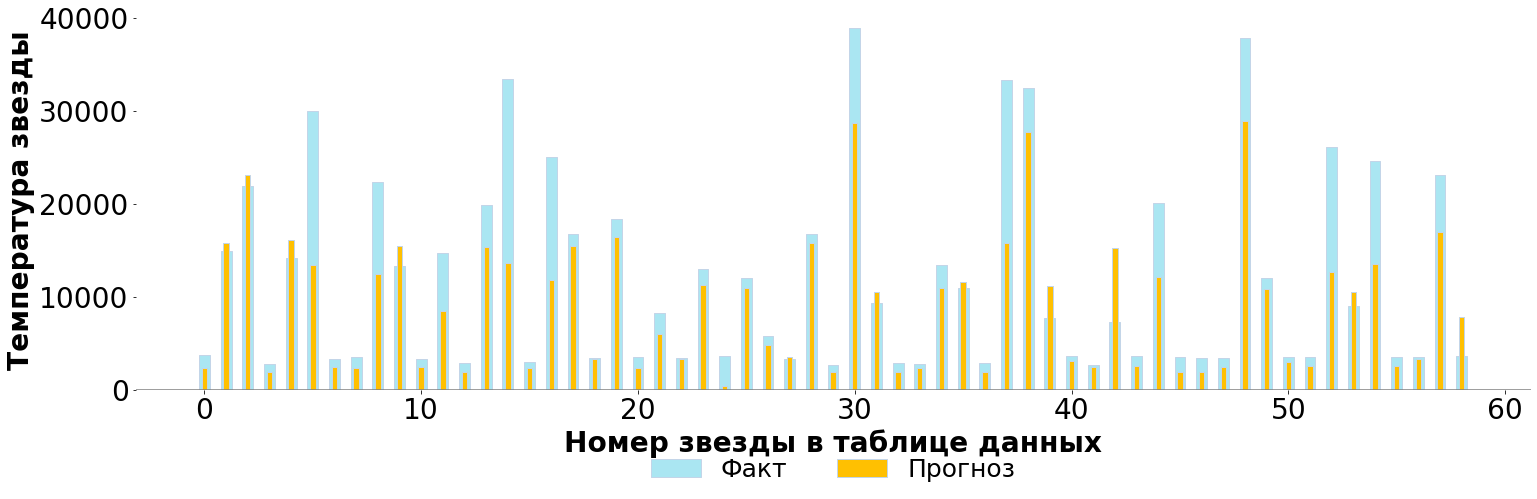

In [341]:
graph_predict(tensor(prediction.reshape(-1)), y_test)

## Выводы

Базовая модель нейронной сети с параметрами n_hidden_neurons_1 = 7, n_hidden_neurons_2 = 12 показала значение RMSE 10552. Улучшили модель, используя перебор количества нейронов в скрытых слоях, а также используем BatchNorm и Dropout. Установили следующие параметры:
- n_in_neurons = 14
- n_hidden_neurons_1 = 95
- n_hidden_neurons_2 = 119
- dropout_1 = 0.8
- dropout_2 = 0.6
- BatchNorn = 95
- BatchNorn_2 = 119
- n_out_neurons = 1
- функция активации после каждого слоя: nn.Tanh, nn.LeakyReLU, nn.ReLU.
    Также для настройки модели использовали EarlyStopping. С данными параметрами нейронной сети мы достигли значения RMSE 4701.